# Qweak Aluminum Transverse Asymmetry Analysis

To do list (as of 2018/11/21):
* Adopt functionality to allow sine fit of horizontial data and a cosine fit of vertical.

In [1]:
import numpy as np
#This following is so that this will work with Latex, see
#http://bkanuka.com/articles/native-latex-plots/
import matplotlib as mpl
mpl.use('pgf')

In [2]:
def figsize(scale):                                 # I think scale is the size you want it on the page
    fig_width_pt = 433.62001                        # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.0                        # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_lualatex = {                      # Setup matplotlib to use latex for output
    "pgf.texsystem": "lualatex",           # Change this if using xetex or luatex
    "text.usetex": True,                   # Use LaTeX to write all text
    #Fonts
    "font.family": "serif",                # Get from the pdf font function on the doc
    "font.serif": "Computer Modern Roman",      
    "font.sans-serif": "Computer Modern Sans serif",
    "font.monospace": [], # Blank entries should cause plots to inherit fonts from the document
    #Text size
    "font.size": 11,# Document default is 11pt font.
    #"text.fontsize": 11,
    "axes.labelsize": 11,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    ##Axis
    #"axes.labelpad": 2,     # space between label and axis 
    "figure.figsize": figsize(1.0),     # default fig size of 1.0 textwidth
    #Packages
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        r"\usepackage{amsmath}",  #need to add math or the ^ won't work
        r"\usepackage{amssymb}"]
    }

mpl.rcParams.update(pgf_with_lualatex)

In [3]:
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns
import uproot
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.special import gamma
from matplotlib.ticker import AutoMinorLocator

In [4]:
print('Requirements:')
print('     Numpy:'+np.__version__)
print('Matplotlib:'+mpl.__version__)
print('    Pandas:'+pd.__version__)
print('   Seaborn:'+sns.__version__)

Requirements:
     Numpy:1.14.3
Matplotlib:2.1.1
    Pandas:0.22.0
   Seaborn:0.8.1


In [5]:
%matplotlib inline
pp.style.use('seaborn-ticks')
sns.set_palette("muted")

In [126]:
# Off (Unregressed)
#r1_v_tfile = uproot.open('/home/kbartlett/Documents/Qweak/ElasticTransverseAluminum/db_rootfiles/run1_al_vertical_elastic/DS-4%-Aluminum_off_tree.root')
#r2_h_tfile = uproot.open('/home/kbartlett/Documents/Qweak/ElasticTransverseAluminum/db_rootfiles/run2_al_horizontal_elastic/DS-4%-Aluminum_off_tree.root')
#r2_v_tfile = uproot.open('/home/kbartlett/Documents/Qweak/ElasticTransverseAluminum/db_rootfiles/run2_al_vertical_elastic/DS-4%-Aluminum_off_tree.root')

# On regression set
r1_v_tfile = uproot.open('/home/kbartlett/Documents/Qweak/ElasticTransverseAluminum/db_rootfiles/run1_al_vertical_elastic/DS-4%-Aluminum_on_set13_tree.root')
r2_h_tfile = uproot.open('/home/kbartlett/Documents/Qweak/ElasticTransverseAluminum/db_rootfiles/run2_al_horizontal_elastic/DS-4%-Aluminum_on_set13_tree.root')
r2_v_tfile = uproot.open('/home/kbartlett/Documents/Qweak/ElasticTransverseAluminum/db_rootfiles/run2_al_vertical_elastic/DS-4%-Aluminum_on_set13_tree.root')

In [127]:
r1_v_tree = r1_v_tfile.get('tree')
r2_h_tree = r2_h_tfile.get('tree')
r2_v_tree = r2_v_tfile.get('tree')

In [128]:
r1_v_tree.fBranches[:13]

[<TBranch b'runlet_id' at 0x7fa774899be0>,
 <TBranch b'run_number' at 0x7fa774899780>,
 <TBranch b'run_number_decimal' at 0x7fa7749356a0>,
 <TBranch b'slug' at 0x7fa774935ef0>,
 <TBranch b'wien_slug' at 0x7fa774935208>,
 <TBranch b'ihwp_setting' at 0x7fa774c6e9b0>,
 <TBranch b'phwp_setting' at 0x7fa774899828>,
 <TBranch b'wien_reversal' at 0x7fa7749355c0>,
 <TBranch b'precession_reversal' at 0x7fa774935a58>,
 <TBranch b'sign_correction' at 0x7fa7749355f8>,
 <TBranch b'qtor_current' at 0x7fa7749353c8>,
 <TBranch b'runlet_quality_id' at 0x7fa7747ae198>,
 <TBranch b'raster_size' at 0x7fa774860438>]

In [129]:
def extract_mds_asym(tree):
    df = pd.DataFrame({'run':tree.get('run_number').array(),
                       'sign_correction':tree.get('sign_correction').array(), 
                       'quality_id':tree.get('runlet_quality_id').array(), 
                       'ihwp':tree.get('ihwp_setting').array()}) 
    for i in np.arange(1,9,1):
        temp_df = pd.DataFrame(tree.get('asym_md{0}pmtavg'.format(i)).array())
        temp_df.columns = pd.Index(['md{0}_'.format(i)+label for label in temp_df.columns])
        df = pd.concat([df,temp_df],axis=1)
    return df

def extract_pmt_asym(tree):
    df = pd.DataFrame({'run':tree.get('run_number').array(),
                       'sign_correction':tree.get('sign_correction').array(), 
                       'quality_id':tree.get('runlet_quality_id').array(), 
                       'ihwp':tree.get('ihwp_setting').array()}) 
    for i in np.arange(1,9,1):
        neg_temp_df = pd.DataFrame(tree.get('asym_qwk_md{0}neg'.format(i)).array())
        neg_temp_df.columns = pd.Index(['md{0}neg_'.format(i)+label for label in neg_temp_df.columns])
        pos_temp_df = pd.DataFrame(tree.get('asym_qwk_md{0}pos'.format(i)).array())
        pos_temp_df.columns = pd.Index(['md{0}pos_'.format(i)+label for label in pos_temp_df.columns])
        df = pd.concat([df,neg_temp_df, pos_temp_df],axis=1)
    return df

In [130]:
def h_fit_function(x, amp, phase, const):
    return amp*np.sin((np.pi/4.0)*x - (np.pi/4.0) + phase) + const

def v_fit_function(x, amp, phase, const):
    return amp*np.cos((np.pi/4.0)*x - (np.pi/4.0) + phase) + const

def h_fit_function_err(x, amp, phase, const, pcov):
    dfdA = h_fit_function(x, 1.0, phase, const)
    dfdP = v_fit_function(x, amp, phase, const)
    dfdC = 1.0
    
    termA = np.diag(pcov)[0]*np.square(dfdA)
    termP = np.diag(pcov)[1]*np.square(dfdP)
    termC = np.diag(pcov)[2]*np.square(dfdC)
    
    termAP = 2.0*pcov[0,1]*dfdA*dfdP
    termAC = 2.0*pcov[0,2]*dfdA*dfdC
    termPC = 2.0*pcov[1,2]*dfdP*dfdC
    
    return np.sqrt(termA + termP + termC + termAP + termAC + termPC)

def v_fit_function_err(x, amp, phase, const, pcov):
    dfdA = v_fit_function(x, 1.0, phase, const)
    dfdP = -1.0*h_fit_function(x, amp, phase, const)
    dfdC = 1.0
    
    termA = np.diag(pcov)[0]*np.square(dfdA)
    termP = np.diag(pcov)[1]*np.square(dfdP)
    termC = np.diag(pcov)[2]*np.square(dfdC)
    
    termAP = 2.0*pcov[0,1]*dfdA*dfdP
    termAC = 2.0*pcov[0,2]*dfdA*dfdC
    termPC = 2.0*pcov[1,2]*dfdP*dfdC
    
    return np.sqrt(termA + termP + termC + termAP + termAC + termPC)

In [131]:
def extract_avgs(df, label=''):
    return np.array([np.average(df['md{0}{1}_value'.format(i, label)],
                     weights=1/np.square(df['md{0}{1}_err'.format(i, label)]), 
                     returned=True) for i in np.arange(1,9,1)])

def extract_sc_avgs(df):
    return np.array([np.average(df['sign_correction']*df['md{0}_value'.format(i)],
                     weights=1/np.square(df['md{0}_err'.format(i)]), 
                     returned=True) for i in np.arange(1,9,1)])

def format_avgs(avgs):
    cv = avgs[:,0]
    err = 1/np.sqrt(avgs[:,1])
    return cv, err

In [132]:
def calc_chi2(data, fit, err, dof):
    chi2 = np.sum(np.square(data-fit)/np.square(err))
    return chi2, chi2/dof

def chi2probdistribution(chi2, dof):
    if chi2 > 0:
        num = np.power(chi2,(dof-2.0)/2.0)*np.exp(-chi2/2.0)
        dem = np.power(2.0,(dof/2.0))*gamma(dof/2.0)
        return num/dem
    elif chi2 == 0:
        return 0
    else:
        print('Chi^2 values < 0 not valid!')
                   
def calc_chi2prob(chi2, dof):
    return quad(chi2probdistribution, chi2, np.inf, (dof))

In [133]:
# Extract MD Asym Data
r1_v_data = extract_mds_asym(r1_v_tree)
r2_h_data = extract_mds_asym(r2_h_tree)
r2_v_data = extract_mds_asym(r2_v_tree)

In [134]:
# Extract POS/NEG PMT Asym Data
r1_v_pmt_data = extract_pmt_asym(r1_v_tree)
r2_h_pmt_data = extract_pmt_asym(r2_h_tree)
r2_v_pmt_data = extract_pmt_asym(r2_v_tree)

In [135]:
# Data cuts (Pandas Dataframe query)
query = 'quality_id == 1'
in_query = 'ihwp == 1 and quality_id ==1'
out_query = 'ihwp == 0 and quality_id ==1'

In [136]:
# Apply cuts to data
r1_v_data_cut = r1_v_data.query(query)
r2_h_data_cut = r2_h_data.query(query)
r2_v_data_cut = r2_v_data.query(query)

# Apply cuts to get ihwp IN and OUT states
r1_v_in_data = r1_v_data.query(in_query)
r1_v_out_data = r1_v_data.query(out_query)
r2_h_in_data = r2_h_data.query(in_query)
r2_h_out_data = r2_h_data.query(out_query)
r2_v_in_data = r2_v_data.query(in_query)
r2_v_out_data = r2_v_data.query(out_query)

# Apply cuts to PMT data
r1_v_pmt_data_cut = r1_v_pmt_data.query(query)
r2_h_pmt_data_cut = r2_h_pmt_data.query(query)
r2_v_pmt_data_cut = r2_v_pmt_data.query(query)

In [137]:
len(r1_v_pmt_data_cut), len(r1_v_pmt_data)

(70, 71)

In [138]:
# Calculated Error Weighted Averages
r1_v_avg, r1_v_avg_err = format_avgs(extract_sc_avgs(r1_v_data_cut))
r2_h_avg, r2_h_avg_err = format_avgs(extract_sc_avgs(r2_h_data_cut))
r2_v_avg, r2_v_avg_err = format_avgs(extract_sc_avgs(r2_v_data_cut))

r1_v_in_avg, r1_v_in_avg_err = format_avgs(extract_avgs(r1_v_in_data))
r1_v_out_avg, r1_v_out_avg_err = format_avgs(extract_avgs(r1_v_out_data))
r2_h_in_avg, r2_h_in_avg_err = format_avgs(extract_avgs(r2_h_in_data))
r2_h_out_avg, r2_h_out_avg_err = format_avgs(extract_avgs(r2_h_out_data))
r2_v_in_avg, r2_v_in_avg_err = format_avgs(extract_avgs(r2_v_in_data))
r2_v_out_avg, r2_v_out_avg_err = format_avgs(extract_avgs(r2_v_out_data))

r1_v_neg_avg, r1_v_neg_avg_err = format_avgs(extract_avgs(r1_v_pmt_data_cut, 'neg'))
r1_v_pos_avg, r1_v_pos_avg_err = format_avgs(extract_avgs(r1_v_pmt_data_cut, 'pos'))
r2_h_neg_avg, r2_h_neg_avg_err = format_avgs(extract_avgs(r2_h_pmt_data_cut, 'neg'))
r2_h_pos_avg, r2_h_pos_avg_err = format_avgs(extract_avgs(r2_h_pmt_data_cut, 'pos'))
r2_v_neg_avg, r2_v_neg_avg_err = format_avgs(extract_avgs(r2_v_pmt_data_cut, 'neg'))
r2_v_pos_avg, r2_v_pos_avg_err = format_avgs(extract_avgs(r2_v_pmt_data_cut, 'pos'))

In [139]:
#md_avgs = pd.DataFrame()

In [140]:
#md_avgs['r1_v_avg'] = r1_v_avg
#md_avgs['r1_v_err'] = r1_v_avg_err
#md_avgs['r2_h_avg'] = r2_h_avg
#md_avgs['r2_h_err'] = r2_h_avg_err
#md_avgs['r2_v_avg'] = r2_v_avg
#md_avgs['r2_v_err'] = r2_v_avg_err

In [141]:
#md_avgs.head()

In [142]:
#md_avgs.to_csv('data/trans_al_unregressed.csv')

In [143]:
md_label = np.arange(1,9,1)

def fit_data(label, avg, avg_err):
    if label[3:] == 'v':
        popt, pcov = curve_fit(v_fit_function, 
                               md_label, 
                               avg, 
                               sigma=avg_err, 
                               absolute_sigma=True, method = 'trf', bounds=([-np.inf, -np.pi/8.0, -np.inf],[np.inf, np.pi/8.0, np.inf]))
        dof = len(md_label)-len(popt)
        chi2, rchi2 = calc_chi2(avg, v_fit_function(md_label, *popt), avg_err, dof)
        prob = calc_chi2prob(chi2, dof)
    elif label[3:] == 'h':
        popt, pcov = curve_fit(h_fit_function, 
                               md_label, 
                               avg, 
                               sigma=avg_err, 
                               absolute_sigma=True, method = 'trf', bounds=([-np.inf, -np.pi/8.0, -np.inf],[np.inf, np.pi/8.0, np.inf]))
        dof = len(md_label)-len(popt)
        chi2, rchi2 = calc_chi2(avg, h_fit_function(md_label, *popt), avg_err, dof)
        prob = calc_chi2prob(chi2, dof)
    else:
        print('Use correct label!')
    
    return popt, pcov, chi2, dof, rchi2, prob

def calc_null(in_avg, in_avg_err, out_avg, out_avg_err):
    null = (in_avg+out_avg)/2.0
    null_err = np.sqrt(0.25*np.square(in_avg_err) + 0.25*np.square(out_avg_err))
    return null, null_err
    
def calc_ewavg(value, value_err):
    avg, sow = np.average(value, weights=1/np.square(value_err), returned=True)
    avg_err = 1/np.sqrt(sow)
    dof = len(value)-1
    chi2, rchi2 = calc_chi2(value, avg, value_err, dof)
    prob = calc_chi2prob(chi2, dof)
    return avg, avg_err, chi2, dof, rchi2, prob

def calc_pmtdd(neg_avg, neg_avg_err, pos_avg, pos_avg_err):
    dd = neg_avg - pos_avg
    dd_err = np.sqrt(np.square(neg_avg_err)+np.square(pos_avg_err))
    return dd, dd_err

def print_fit_stats(label, popt, pcov, rchi2, prob):
    if label == 'NULL' or label == 'PMTDD':
        print('----------{0}----------'.format(label))
        print('    Constant: {0:.5}+-{1:.5} [ppm]'.format(np.round(popt, 4), np.round(pcov,4)))
        print('       RChi2: {0:.5}'.format(np.round(rchi2, 4)))
        print('        Prob: {0:.5}'.format(np.round(prob[0], 4)))
    else:
        print('----------{0}----------'.format(label))
        print('   Amplitude: {0:.5}+-{1:.5} [ppm]'.format(np.round(popt[0], 4), np.round(np.sqrt(np.diag(pcov))[0], 4)))
        print('Phase Offset: {0:.5}+-{1:.5} [rad]'.format(np.round(popt[1], 4), np.round(np.sqrt(np.diag(pcov))[1], 4)))
        print('    Constant: {0:.5}+-{1:.5} [ppm]'.format(np.round(popt[2], 4), np.round(np.sqrt(np.diag(pcov))[2], 4)))
        print('       RChi2: {0:.5}'.format(np.round(rchi2, 4)))
        print('        Prob: {0:.5}'.format(np.round(prob[0], 4)))

In [144]:
# Fit transverse MD asymmetries
r1_v_popt, r1_v_pcov, r1_v_chi2, r1_v_dof, r1_v_rchi2, r1_v_fit_prob = fit_data('r1_v', r1_v_avg, r1_v_avg_err)
r2_h_popt, r2_h_pcov, r2_h_chi2, r2_h_dof, r2_h_rchi2, r2_h_fit_prob = fit_data('r2_h', r2_h_avg, r2_h_avg_err)
r2_v_popt, r2_v_pcov, r2_v_chi2, r2_v_dof, r2_v_rchi2, r2_v_fit_prob = fit_data('r2_v', r2_v_avg, r2_v_avg_err)

# Fit transverse MD IN/OUT asymmetries
r1_v_in_popt, r1_v_in_pcov, r1_v_in_chi2, r1_v_in_dof, r1_v_in_rchi2, r1_v_in_fit_prob = fit_data('r1_v', r1_v_in_avg, r1_v_in_avg_err)
r1_v_out_popt, r1_v_out_pcov, r1_v_out_chi2, r1_v_out_dof, r1_v_out_rchi2, r1_v_out_fit_prob = fit_data('r1_v', r1_v_out_avg, r1_v_out_avg_err)
r2_h_in_popt, r2_h_in_pcov, r2_h_in_chi2, r2_h_in_dof, r2_h_in_rchi2, r2_h_in_fit_prob = fit_data('r2_h', r2_h_in_avg, r2_h_in_avg_err)
r2_h_out_popt, r2_h_out_pcov, r2_h_out_chi2, r2_h_out_dof, r2_h_out_rchi2, r2_h_out_fit_prob = fit_data('r2_h', r2_h_out_avg, r2_h_out_avg_err)
r2_v_in_popt, r2_v_in_pcov, r2_v_in_chi2, r2_v_in_dof, r2_v_in_rchi2, r2_v_in_fit_prob = fit_data('r2_v', r2_v_in_avg, r2_v_in_avg_err)
r2_v_out_popt, r2_v_out_pcov, r2_v_out_chi2, r2_v_out_dof, r2_v_out_rchi2, r2_v_out_fit_prob = fit_data('r2_v', r2_v_out_avg, r2_v_out_avg_err)

In [145]:
md_fit_range = np.linspace(0.5,8.5,1000)

In [146]:
def plot(label, avg, avg_err, popt, pcov, rchi2, prob):
    fig, ax = pp.subplots(figsize=figsize(0.9))
    ax.errorbar(md_label, 
                avg, 
                yerr=avg_err, 
                ls='None', 
                marker='d', 
                capsize=2.0, 
                capthick=1.0, 
                barsabove=True, 
                color=sns.xkcd_rgb['dull blue'])
    if label[3:] == 'v':
        ax.plot(md_fit_range, v_fit_function(md_fit_range, *popt), zorder=-10, color=sns.xkcd_rgb['dull red'])
        ax.fill_between(md_fit_range, 
                        v_fit_function(md_fit_range, *popt)-v_fit_function_err(md_fit_range, *popt, pcov), 
                        v_fit_function(md_fit_range, *popt)+v_fit_function_err(md_fit_range, *popt, pcov), 
                        color=sns.xkcd_rgb['dull red'], 
                        alpha=0.2)
    elif label[3:] == 'h':
        ax.plot(md_fit_range, h_fit_function(md_fit_range, *popt), zorder=-10, color=sns.xkcd_rgb['dull red'])
        ax.fill_between(md_fit_range, 
                        h_fit_function(md_fit_range, *popt)-h_fit_function_err(md_fit_range, *popt, pcov), 
                        h_fit_function(md_fit_range, *popt)+h_fit_function_err(md_fit_range, *popt, pcov), 
                        color=sns.xkcd_rgb['dull red'], 
                        alpha=0.2)
    ax.set_xlim(0.5, 8.5)
    ax.set_xlabel('Main Detector')
    ax.set_ylabel('Asymmetry [ppm]')
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    print_fit_stats('PHYS', popt, pcov, rchi2, prob)
    #pp.savefig('plots/al_trans_{0}_phys_asym_on.png'.format(label), bbox_inches='tight')
    #pp.savefig('plots/al_trans_{0}_phys_asym_on.pdf'.format(label), bbox_inches='tight')
    #pp.savefig('plots/al_trans_{0}_phys_asym_on.pgf'.format(label), bbox_inches='tight')
    pp.show()

In [147]:
def null_plot(label, in_avg, in_avg_err, in_popt, in_pcov, in_rchi2, in_prob, out_avg, out_avg_err, out_popt, out_pcov, out_rchi2, out_prob):
    fig, ax = pp.subplots(figsize=figsize(0.9))
    # Plot In states 
    ax.errorbar(md_label, 
                in_avg, 
                yerr=in_avg_err, 
                ls='None', 
                marker='s', 
                capsize=2.0, 
                capthick=1.0, 
                barsabove=True,
                color=sns.xkcd_rgb['dull purple'], 
                label='In')
    if label[3:] == 'v':
        ax.plot(md_fit_range, v_fit_function(md_fit_range, *in_popt), zorder=-10, color=sns.xkcd_rgb['dull purple'], label='In Fit')
        ax.fill_between(md_fit_range, 
                        v_fit_function(md_fit_range, *in_popt)-v_fit_function_err(md_fit_range, *in_popt, in_pcov), 
                        v_fit_function(md_fit_range, *in_popt)+v_fit_function_err(md_fit_range, *in_popt, in_pcov), 
                        color=sns.xkcd_rgb['dull purple'], 
                        alpha=0.2 )
    elif label[3:] == 'h':
        ax.plot(md_fit_range, h_fit_function(md_fit_range, *in_popt), zorder=-10, color=sns.xkcd_rgb['dull purple'], label='In Fit')
        ax.fill_between(md_fit_range, 
                        h_fit_function(md_fit_range, *in_popt)-h_fit_function_err(md_fit_range, *in_popt, in_pcov), 
                        h_fit_function(md_fit_range, *in_popt)+h_fit_function_err(md_fit_range, *in_popt, in_pcov), 
                        color=sns.xkcd_rgb['dull purple'], 
                        alpha=0.2 )
    # Plot Out states
    ax.errorbar(md_label, 
                out_avg, 
                yerr=out_avg_err, 
                ls='None', 
                marker='o', 
                capsize=2.0, 
                capthick=1.0, 
                barsabove=True, 
                color=sns.xkcd_rgb['dull orange'], 
                label='Out')
    if label[3:] == 'v':
        ax.plot(md_fit_range, v_fit_function(md_fit_range, *out_popt), zorder=-10, color=sns.xkcd_rgb['dull orange'], label='Out Fit')
        ax.fill_between(md_fit_range, 
                        v_fit_function(md_fit_range, *out_popt)-v_fit_function_err(md_fit_range, *out_popt, out_pcov), 
                        v_fit_function(md_fit_range, *out_popt)+v_fit_function_err(md_fit_range, *out_popt, out_pcov), 
                        color=sns.xkcd_rgb['dull orange'], 
                        alpha=0.2 )
    elif label[3:] == 'h':
        ax.plot(md_fit_range, h_fit_function(md_fit_range, *out_popt), zorder=-10, color=sns.xkcd_rgb['dull orange'], label='Out Fit')
        ax.fill_between(md_fit_range, 
                        h_fit_function(md_fit_range, *out_popt)-h_fit_function_err(md_fit_range, *out_popt, out_pcov), 
                        h_fit_function(md_fit_range, *out_popt)+h_fit_function_err(md_fit_range, *out_popt, out_pcov), 
                        color=sns.xkcd_rgb['dull orange'], 
                        alpha=0.2 )
    # Plot NULL
    null, null_err = calc_null(in_avg, in_avg_err, out_avg, out_avg_err)
    null_avg, null_avg_err, null_chi2, null_dof, null_rchi2, null_prob = calc_ewavg(null, null_err)
    ax.errorbar(md_label, 
                null, 
                yerr=null_err, 
                ls='None', 
                marker='d', 
                capsize=2.0, 
                capthick=1.0, 
                barsabove=True, 
                color=sns.xkcd_rgb['dull green'], 
                label='Null')
    ax.plot([0.5, 8.5], [null_avg, null_avg], zorder=-10, color=sns.xkcd_rgb['dull green'], label='Null Avg')
    ax.fill_between([0.5, 8.5], 
                    null_avg-null_avg_err, 
                    null_avg+null_avg_err, 
                    color=sns.xkcd_rgb['dull green'], 
                    alpha=0.2)
    ax.set_xlim(0.5, 8.5)
    ax.set_xlabel('Main Detector')
    ax.set_ylabel('Asymmetry [ppm]')
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.legend(loc='upper left', bbox_to_anchor=(1.02,1.0))
    print_fit_stats('IN', in_popt, in_pcov, in_rchi2, in_prob)
    print_fit_stats('OUT', out_popt, out_pcov, out_rchi2, out_prob)
    print_fit_stats('NULL', null_avg, null_avg_err, null_rchi2, null_prob)
    #pp.savefig('plots/al_trans_{0}_null_asym_on.png'.format(label), bbox_inches='tight')
    #pp.savefig('plots/al_trans_{0}_null_asym_on.pdf'.format(label), bbox_inches='tight')
    #pp.savefig('plots/al_trans_{0}_null_asym_on.pgf'.format(label), bbox_inches='tight')
    pp.show()

----------PHYS----------
   Amplitude: 0.0+-5.977e+04 [ppm]
Phase Offset: -0.0388+-0.0 [rad]
    Constant: -5.7143e+04+-4.2258e+04 [ppm]
       RChi2: 0.0
        Prob: 1.0


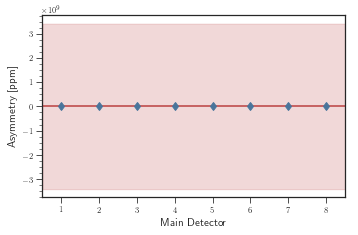

In [148]:
plot('r1_v', r1_v_avg, r1_v_avg_err, r1_v_popt, r1_v_pcov, r1_v_rchi2, r1_v_fit_prob)

----------PHYS----------
   Amplitude: -8.4895+-0.4992 [ppm]
Phase Offset: 0.0519+-0.0588 [rad]
    Constant: -0.0988+-0.353 [ppm]
       RChi2: 1.1717
        Prob: 0.3202


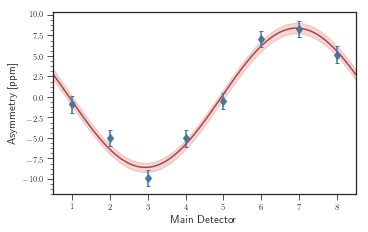

In [149]:
plot('r2_h', r2_h_avg, r2_h_avg_err, r2_h_popt, r2_h_pcov, r2_h_rchi2, r2_h_fit_prob)

----------PHYS----------
   Amplitude: -8.6329+-0.7271 [ppm]
Phase Offset: -0.011+-0.0842 [rad]
    Constant: 0.1928+-0.514 [ppm]
       RChi2: 0.6205
        Prob: 0.6842


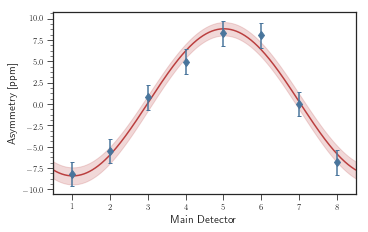

In [150]:
plot('r2_v', r2_v_avg, r2_v_avg_err, r2_v_popt, r2_v_pcov, r2_v_rchi2, r2_v_fit_prob)

In [ ]:
def calc_combined_phys_asym(r1_v_asym, r1_v_asym_err, r2_h_asym, r2_h_asym_err, r2_v_asym, r2_v_asym_err):
    asym = [r1_v_asym, r2_h_asym, r2_v_asym]
    err = [r1_v_asym_err, r2_h_asym_err, r2_v_asym_err]
    avg, sow = np.average(asym, weights=1/np.square(err), returned=True)
    avg_err = 1/np.sqrt(sow)
    print(' Combined Phys. Asym: {0:.5}+-{1:.5} [ppm]'.format(avg, avg_err))
    print('Relative Uncertainty: {0:.5}%'.format(100.0*np.abs(avg_err/avg)))

In [ ]:
fig, ax = pp.subplots(figsize=figsize(0.9))
ax.errorbar([0,1,2], 
            [r1_v_popt[0], r2_h_popt[0], r2_v_popt[0]],
            yerr=[np.sqrt(np.diag(r1_v_pcov)[0]), np.sqrt(np.diag(r2_h_pcov)[0]), np.sqrt(np.diag(r2_v_pcov)[0])],
            ls='None', marker='d', color=sns.xkcd_rgb['dull blue'])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Run 1 Vertical', 'Run2 Horizontal.', 'Run2 Vertical'])
ax.set_ylim(-10.0, -7.0)
ax.set_ylabel('Asymmetry [ppm]')
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
pp.show()

In [ ]:
calc_combined_phys_asym(r1_v_popt[0], 
                        np.sqrt(np.diag(r1_v_pcov)[0]), 
                        r2_h_popt[0], 
                        np.sqrt(np.diag(r2_h_pcov)[0]), 
                        r2_v_popt[0], 
                        np.sqrt(np.diag(r2_v_pcov)[0]))

In [ ]:
null_plot('r1_v',
          r1_v_in_avg, 
          r1_v_in_avg_err, 
          r1_v_in_popt, 
          r1_v_in_pcov, 
          r1_v_in_rchi2, 
          r1_v_in_fit_prob, 
          r1_v_out_avg, 
          r1_v_out_avg_err, 
          r1_v_out_popt, 
          r1_v_out_pcov, 
          r1_v_out_rchi2, 
          r1_v_out_fit_prob)

In [ ]:
null_plot('r2_h',
          r2_h_in_avg, 
          r2_h_in_avg_err, 
          r2_h_in_popt, 
          r2_h_in_pcov, 
          r2_h_in_rchi2, 
          r2_h_in_fit_prob, 
          r2_h_out_avg, 
          r2_h_out_avg_err, 
          r2_h_out_popt, 
          r2_h_out_pcov, 
          r2_h_out_rchi2, 
          r2_h_out_fit_prob)

In [ ]:
null_plot('r2_v',
          r2_v_in_avg, 
          r2_v_in_avg_err, 
          r2_v_in_popt, 
          r2_v_in_pcov, 
          r2_v_in_rchi2, 
          r2_v_in_fit_prob, 
          r2_v_out_avg, 
          r2_v_out_avg_err, 
          r2_v_out_popt, 
          r2_v_out_pcov, 
          r2_v_out_rchi2, 
          r2_v_out_fit_prob)

In [ ]:
# Calculate PMT DD for the transverse datasets
r1_v_pmtdd, r1_v_pmtdd_err = calc_pmtdd(r1_v_neg_avg, r1_v_neg_avg_err, r1_v_pos_avg, r1_v_pos_avg_err)
r2_h_pmtdd, r2_h_pmtdd_err = calc_pmtdd(r2_h_neg_avg, r2_h_neg_avg_err, r2_h_pos_avg, r2_h_pos_avg_err)
r2_v_pmtdd, r2_v_pmtdd_err = calc_pmtdd(r2_v_neg_avg, r2_v_neg_avg_err, r2_v_pos_avg, r2_v_pos_avg_err)

In [ ]:
def pmtdd_plot(label, dd, dd_err):
    pp.figure(figsize=figsize(1))
    dd_avg, dd_avg_err, dd_chi2, dd_dof, dd_rchi2, dd_prob = calc_ewavg(dd, dd_err)
    pp.errorbar(md_label, dd, yerr=dd_err, ls='None', marker='d', color=sns.xkcd_rgb['dull blue'])
    pp.plot([0.5, 8.5], [dd_avg, dd_avg], color=sns.xkcd_rgb['dull red'])
    pp.fill_between([0.5, 8.5], dd_avg-dd_avg_err, dd_avg+dd_avg_err, color=sns.xkcd_rgb['dull red'], alpha=0.2)
    pp.tick_params(top=False)
    pp.xlim(0.5, 8.5)
    pp.xlabel('Main Detector')
    pp.ylabel('PMT Double Difference Asymmetry [ppm]')
    #pp.legend(loc='upper left', bbox_to_anchor=(1.02,1))
    print_fit_stats('PMTDD', dd_avg, dd_avg_err, dd_rchi2, dd_prob)
    pp.savefig('plots/al_trans_{0}_pmtdd_asym.png'.format(label), bbox_inches='tight')
    pp.savefig('plots/al_trans_{0}_pmtdd_asym.pdf'.format(label), bbox_inches='tight')
    pp.savefig('plots/al_trans_{0}_pmtdd_asym.pgf'.format(label), bbox_inches='tight')
    pp.show()

In [ ]:
pmtdd_plot('r1_v', r1_v_pmtdd, r1_v_pmtdd_err)

In [ ]:
pmtdd_plot('r2_h',r2_h_pmtdd, r2_h_pmtdd_err)

In [ ]:
pmtdd_plot('r2_v', r2_v_pmtdd, r2_v_pmtdd_err)